- Uid: u1428543
- Date: Jun 2, 2023
- Class: CS6017

# Homework 3 - Scraping and Regression

## Part 1 - Data Acquisition


In [434]:
import datetime
from math import floor


def calculate_time_gap(timestamp_string):
    timestamp = datetime.datetime.fromisoformat(timestamp_string)

    # Greenwich mean time is 6 hours ahead of MST
    adjusted_time = timestamp - datetime.timedelta(hours=6)

    current_time = datetime.datetime.now()

    time_gap = (current_time - adjusted_time).total_seconds() / 3600

    return floor(time_gap)


In [435]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

hackernews_file = 'hackernews_stories.csv'



def scrape_hackernews_stories():
    stories_data = []

    for page in range(1, 6): 
        url = f"https://news.ycombinator.com/news?p={page}"
        response = requests.get(url)
        soup = BeautifulSoup(response.text, "html.parser")
        story_rows = soup.select(".athing")

        for row in story_rows:
            rank = row.find(class_="rank").text.strip(".")
            title = row.find(class_="titleline").text

            next_row = row.find_next_sibling("tr")
           
            if next_row:
                original_age_string = next_row.find(class_="age")['title']
                age = calculate_time_gap(original_age_string)
                points = next_row.find(class_="score").text.split()[
                    0] if next_row.find(class_="score") else "0"
                comments = next_row.find("a", href=lambda href: href and "item?id" in href).text.split()[
                    0] if next_row.find("a", href=lambda href: href and "item?id" in href) else "0"
            else:
                age = "N/A"
                points = "N/A"
                comments = "N/A"


            stories_data.append({
                "Rank": rank,
                "Title": title,
                "Age(hours)": age,
                "Points": points,
                "Comments": comments
            })

    df = pd.DataFrame(stories_data)
    df.to_csv(hackernews_file, index=False)
    print(f"Scraping completed. Data saved to {hackernews_file}.")

# uncomment the next line to get new data
# scrape_hackernews_stories()


## Part 2 - Regression

### Model 1: Multilinear regression with Title length, Age, Points, Comments

In [436]:
import pandas as pd
import statsmodels.api as sm

df = pd.read_csv(hackernews_file)

df['Title Length'] = df['Title'].apply(len)

X = df[['Title Length', 'Age(hours)', 'Points', 'Comments']]
y = df['Rank']

X = sm.add_constant(X)

linear_reg = sm.OLS(y, X)
linear_reg_result = linear_reg.fit()

y_pred = linear_reg_result.predict(X)

print(linear_reg_result.summary())


                            OLS Regression Results                            
Dep. Variable:                   Rank   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     17.37
Date:                Mon, 12 Jun 2023   Prob (F-statistic):           1.15e-11
Time:                        21:28:00   Log-Likelihood:                -748.70
No. Observations:                 150   AIC:                             1507.
Df Residuals:                     145   BIC:                             1522.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           45.1313     11.871      3.802   

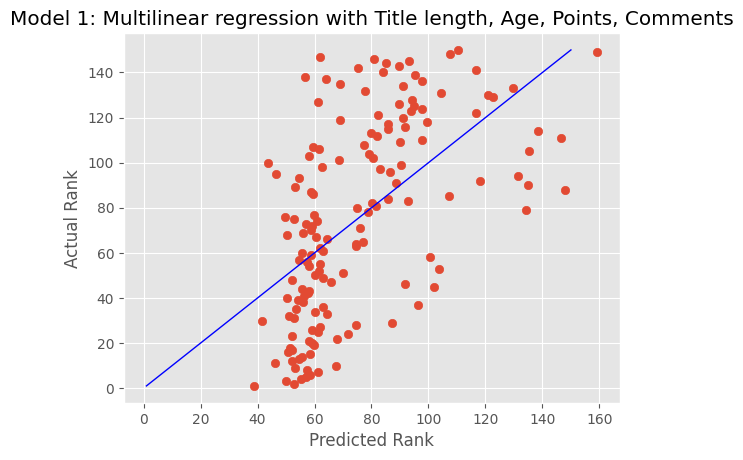

In [437]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

def plot_regression_results(y_pred, y_test, plot_title):
    plt.scatter(y_pred, y_test)
    plt.plot(y_test, y_test, color='blue', linewidth=1)  
    plt.xlabel('Predicted Rank')
    plt.ylabel('Actual Rank')
    plt.title(plot_title)
    plt.show()


plot_regression_results(
    y_pred, y, 'Model 1: Multilinear regression with Title length, Age, Points, Comments')


### Model 2: Polynomial regression with age, age^2, points, points^2 

In [438]:
import pandas as pd
import statsmodels.api as sm

X = df[['Age(hours)', 'Points']].copy()
y = df['Rank']

X['Points^2'] = X['Points'] ** 2
X['Age(hours)^2'] = X['Age(hours)'] ** 2

X = sm.add_constant(X)

# Fit the polynomial regression model
polynomial_reg = sm.OLS(y, X)
polynomial_reg_result = polynomial_reg.fit()

y_pred = polynomial_reg_result.predict(X)

# Print the summary of the polynomial regression model
print(polynomial_reg_result.summary())


                            OLS Regression Results                            
Dep. Variable:                   Rank   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     27.71
Date:                Mon, 12 Jun 2023   Prob (F-statistic):           4.29e-17
Time:                        21:28:00   Log-Likelihood:                -735.48
No. Observations:                 150   AIC:                             1481.
Df Residuals:                     145   BIC:                             1496.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           44.8053      5.275      8.494   

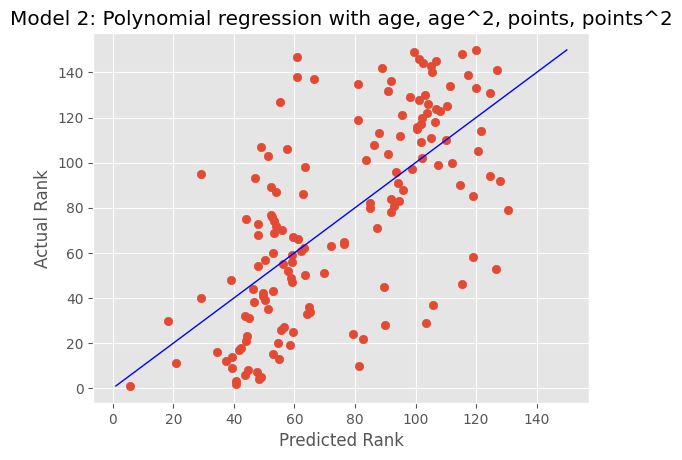

In [439]:
plot_regression_results(
    y_pred, y, 'Model 2: Polynomial regression with age, age^2, points, points^2')


### Model 3: Lasso regression with Title length, Age, Points and Comments

In [440]:
from sklearn.metrics import mean_squared_error
X = df[['Title Length', 'Age(hours)', 'Points', 'Comments']]
y = df['Rank']

X = sm.add_constant(X)


lasso_reg = sm.OLS(y, X)
lasso_reg_result = lasso_reg.fit_regularized(
    alpha=1, L1_wt=1) 

print(lasso_reg_result.params)

# Calculate predictions
y_pred = lasso_reg_result.predict(X)

# Calculate mean squared error (MSE)
mse = mean_squared_error(y, y_pred)
print("Mean Squared Error (MSE):", mse)

# Calculate R-squared
tss = ((y - y.mean()) ** 2).sum()
rss = ((y - y_pred) ** 2).sum()
r_squared = 1 - (rss / tss)
print("R-squared:", r_squared)


const           30.196591
Title Length     0.308817
Age(hours)       1.511326
Points          -0.020736
Comments         0.000000
dtype: float64
Mean Squared Error (MSE): 1281.4807994633438
R-squared: 0.31651319642828013


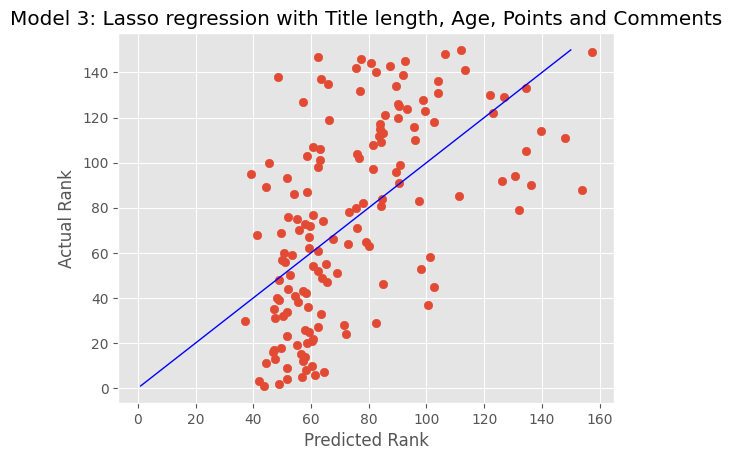

In [441]:
plot_regression_results(
    y_pred, y, 'Model 3: Lasso regression with Title length, Age, Points and Comments')



### Which model is the most useful?

Based on the R^2 scores and coefficients, the ranking of the usefulness of the three models is as follows:

1. Model 2 (R^2 = 0.433)
2. Model 1 (R^2 = 0.324)
3. Model 3 (R^2 = 0.316)

Among the three models, Model 2 stands out as the most useful. It has the highest R^2 score, indicating a better fit to the data and a higher degree of explained variance. 

The coefficients in Model 2 are very interesting. 

The coefficient of Age(hours) is positive (3.4589), but that of Age(hours)^2 is negative (-0.0333). This means that as the Age(hours) increases, the decrease in Rank becomes more pronounced at a decreasing rate. In other words, older posts tend to have lower ranks, but the impact decreases as the Age(hours) increases further.

The coefficient of Points is negative (-0.1032) but that of Points^2 is a nearly 0 positive one (5.396e-05). This means that as the Points increases, the rank also decreases. More upvotes means higher ranking. The positive coefficient of Points^2 indicates that there is an upward curving relationship between Points and Rank. However, the coefficient value is very small, indicating that the impact of the squared term is minimal compared to the linear term of Points.



### Are there linear relationships between any of the variables? 



              Title Length  Age(hours)    Points  Comments
Title Length      1.000000   -0.104629 -0.087970  0.052455
Age(hours)       -0.104629    1.000000  0.174164 -0.065444
Points           -0.087970    0.174164  1.000000 -0.068964
Comments          0.052455   -0.065444 -0.068964  1.000000


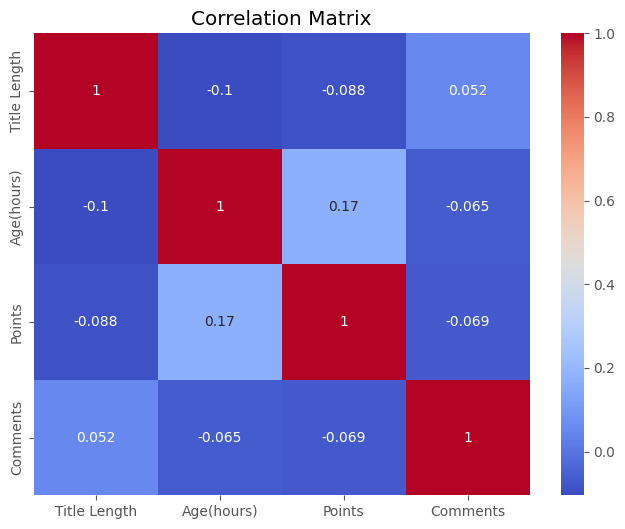

In [442]:
import seaborn as sns

X = df[['Title Length', 'Age(hours)', 'Points', 'Comments']]

correlation_matrix = X.corr()

print(correlation_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


Overall, the correlations between these variables are relatively weak, with most values close to zero. This suggests that there is no strong linear relationship between these variables. However, it's important to note that correlation measures linear relationships and may not capture complex dependencies or non-linear associations between the variables.

## Part 3 - Classification

The formula:

$Score = \frac{Points - 1}{(Age(hours) + 2)^{1.8}}$

In [443]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import pandas as pd
first_page_threshold_rank = 30

df['Front Page'] = np.where(df['Rank'] <= first_page_threshold_rank, 1, 0)

df['Score'] = (df['Points'] - 1) / (df['Age(hours)'] + 2) ** 1.8

# Sort DataFrame by 'Score' in descending order
df = df.sort_values(by='Score', ascending=False)

# Initialize 'Predicted Front Page' column with 0 for all rows
df['Predicted Front Page'] = 0

# Assign 1 to top 30 rows
df.loc[:first_page_threshold_rank - 1,
       'Predicted Front Page'] = 1


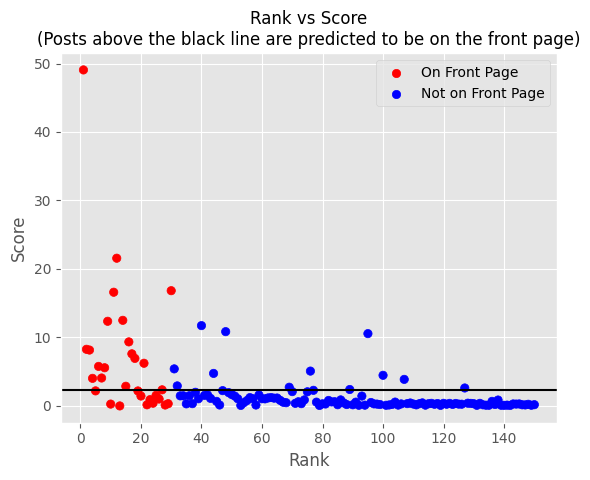

In [444]:

colors = ['blue', 'red']
front_page_colors = [colors[fp] for fp in df['Front Page']]

plt.scatter(df['Rank'], df['Score'], c=front_page_colors)
plt.axhline(y=df.iloc[first_page_threshold_rank - 1]
            ['Score'], color='black')
plt.xlabel('Rank')
plt.ylabel('Score')

# Set the title with different font sizes
plt.title('Rank vs Score\n(Posts above the black line are predicted to be on the front page)',
          fontsize=12)

# Add legends
plt.scatter([], [], color='red', label='On Front Page')
plt.scatter([], [], color='blue', label='Not on Front Page')
plt.legend()

plt.show()


Optimization terminated successfully.
         Current function value: 0.382944
         Iterations 7


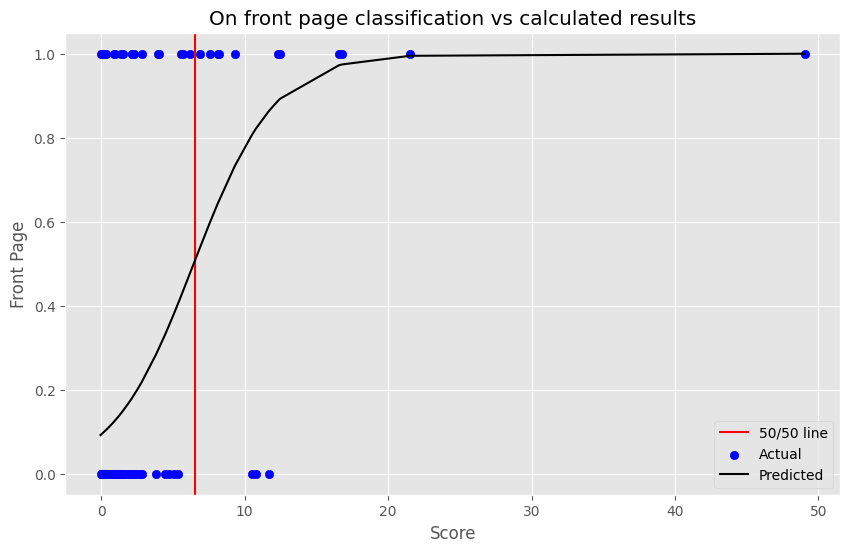

In [445]:
import statsmodels.api as sm

X = df[['Score']]
y = df['Front Page']

# Add constant term to X
X = sm.add_constant(X)

# Perform logistic regression
logit_model = sm.Logit(y, X)
logit_result = logit_model.fit()

# Predict the probabilities
y_pred_proba = logit_result.predict(X)

# Find the x value when y >= 0.5
x_half_upper = X[y_pred_proba >= 0.5]['Score'].min()

# Find the x value when y <= 0.5
x_half_lower = X[y_pred_proba <= 0.5]['Score'].max()

x_half = (x_half_upper + x_half_lower)/2

plt.figure(figsize=(10, 6))

# Adding a red line where x = half_x
plt.axvline(x=x_half, color='red', label='50/50 line')

# Plot the logistic regression curve
plt.scatter(df['Score'], df['Front Page'], color='blue', label='Actual')
plt.plot(df['Score'], y_pred_proba, color='black', label='Predicted')
plt.xlabel('Score')
plt.ylabel('Front Page')
plt.title('On front page classification vs calculated results')
plt.legend()
plt.show()


In [446]:
# Print the model summary
print(logit_result.summary())


                           Logit Regression Results                           
Dep. Variable:             Front Page   No. Observations:                  150
Model:                          Logit   Df Residuals:                      148
Method:                           MLE   Df Model:                            1
Date:                Mon, 12 Jun 2023   Pseudo R-squ.:                  0.2347
Time:                        21:28:01   Log-Likelihood:                -57.442
converged:                       True   LL-Null:                       -75.060
Covariance Type:            nonrobust   LLR p-value:                 2.919e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.2687      0.303     -7.492      0.000      -2.862      -1.675
Score          0.3521      0.080      4.386      0.000       0.195       0.509


1. Significance of Predictor Variables: Both the constant (const) and the Score variable are statistically significant at a significance level of 0.05. This suggests that both variables have a significant impact on the likelihood of making the front page.

2. Coefficient Interpretation: The coefficient for the Score variable is 0.3521. This positive coefficient indicates that a higher Score is associated with a higher likelihood of making the front page.

3. Pseudo R-squared: The Pseudo R-squared value of 0.2347 suggests that the logistic regression model explains approximately 23.47% of the variability in making the front page. This indicates a relatively poor explanatory power.
   
4. The LLR p-value of 2.919e-09 suggests that the logistic regression model as a whole is statistically significant in predicting the likelihood of making the front page.

###  What do the regressions tell you about making the front page?

Posts with more engagement from the community, as reflected by comments and points, have a higher chance of making it to the front page.

Also, newer posts and posts with concise titles tend to have a better chance of reaching the front page.